In [4]:
import matplotlib.pylab as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

from pandas_util import normalize_columns

In [3]:
mower_df = pd.read_csv("./datasets/dmba/RidingMowers.csv")
mower_df.head()

,Income,Lot_Size,Ownership
0,60.0,18.4,Owner
1,85.5,16.8,Owner
2,64.8,21.6,Owner
3,61.5,20.8,Owner
4,87.0,23.6,Owner


In [5]:
normalize_columns(mower_df)
mower_df["number"] = mower_df.index + 1

In [10]:
# new household
new_household = pd.DataFrame([{"income": 60, "lot_size": 20}])
new_household

,income,lot_size
0,60,20


In [11]:
train_data, valid_data = train_test_split(mower_df, test_size=0.4, random_state=26)

In [15]:
def plot_dataset(ax, data, show_label=True, **kwargs):
    """scatterplot"""
    subset = data.loc[data["ownership"] == "Owner"]
    ax.scatter(
        subset.income,
        subset.lot_size,
        marker="o",
        label="Owner" if show_label else None,
        color="C1",
        **kwargs
    )

    subset = data.loc[data["ownership"] == "Nonowner"]
    ax.scatter(
        subset.income,
        subset.lot_size,
        marker="D",
        label="Nonowner" if show_label else None,
        color="C0",
        **kwargs
    )
    plt.xlabel("Income")
    plt.ylabel("Lot Size")
    for _, row in data.iterrows():
        ax.annotate(row.number, (row.income + 2, row.lot_size))

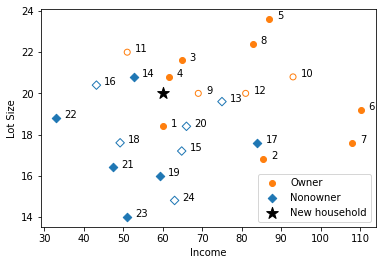

In [16]:
fig, ax = plt.subplots()
plot_dataset(ax, train_data)
plot_dataset(ax, valid_data, show_label=False, facecolors="none")
ax.scatter(
    new_household.income,
    new_household.lot_size,
    marker="*",
    label="New household",
    color="black",
    s=150,
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=4)

## Normalizing data and finding nearest neighbors

In [19]:
predictors = ["income", "number"]
outcome = "ownership"

scaler = preprocessing.StandardScaler()
scaler.fit(train_data[["income", "lot_size"]])

StandardScaler()

In [22]:
mower_norm = pd.concat(
    [
        pd.DataFrame(
            scaler.transform(mower_df[["income", "lot_size"]]),
            columns=["zincome", "zlot_size"],
        ),
        mower_df[["ownership", "number"]],
    ],
    axis=1,
)
mower_norm

,zincome,zlot_size,ownership,number
0,-0.477910,-0.174908,Owner,1
1,0.680365,-0.787085,Owner,2
2,-0.259882,1.049447,Owner,3
3,-0.409776,0.743358,Owner,4
4,0.748499,1.814668,Owner,5
5,1.797760,0.131181,Owner,6
6,1.702373,-0.480996,Owner,7
7,0.557724,1.355535,Owner,8
8,-0.069107,0.437269,Owner,9
9,1.021034,0.743358,Owner,10


In [23]:
train_norm = mower_norm.iloc[train_data.index]
valid_norm = mower_norm.iloc[valid_data.index]
new_household_norm = pd.DataFrame(
    scaler.transform(new_household), columns=["zincome", "zlot_size"]
)

In [24]:
# use NearestNeighbors from scikit-learn to compute knn
knn = NearestNeighbors(n_neighbors=3)
knn.fit(train_norm.iloc[:, 0:2])
distances, indices = knn.kneighbors(new_household_norm)

In [28]:
# Indices is a list of lists, we are only interested in the first element
train_norm.iloc[indices[0], :]

,zincome,zlot_size,ownership,number
3,-0.409776,0.743358,Owner,4
13,-0.804953,0.743358,Nonowner,14
0,-0.477910,-0.174908,Owner,1


## Accuracy of knn predictions in validation set for various choices of k

In [33]:
train_X = train_norm[["zincome", "zlot_size"]]
train_y = train_norm["ownership"]
valid_X = valid_norm[["zincome", "zlot_size"]]
valid_y = valid_norm["ownership"]

In [34]:
# Train a classifier for different values of k
results = []
for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({"k": k, "accuracy": accuracy_score(valid_y, knn.predict(valid_X))})

# Convert results to a pandas data frame
results = pd.DataFrame(results)
results

,k,accuracy
0,1,0.6
1,2,0.7
2,3,0.8
3,4,0.9
4,5,0.7
5,6,0.9
6,7,0.9
7,8,0.9
8,9,0.9
9,10,0.8


In [35]:
# Retrain with the full dataset
mower_X = mower_norm[["zincome", "zlot_size"]]
mower_y = mower_norm["ownership"]

knn = KNeighborsClassifier(n_neighbors=4).fit(mower_X, mower_y)

distances, indices = knn.kneighbors(new_household_norm)
print(knn.predict(new_household_norm))
print("Distances", distances)
print("Indices", indices)
print(mower_norm.iloc[indices[0], :])

['Owner']
Distances [[0.31358009 0.40880312 0.44793643 0.61217726]]
Indices [[ 3  8 13  0]]
     zincome  zlot_size ownership  number
3  -0.409776   0.743358     Owner       4
8  -0.069107   0.437269     Owner       9
13 -0.804953   0.743358  Nonowner      14
0  -0.477910  -0.174908     Owner       1
